<a href="https://colab.research.google.com/github/hungtrieu07/VietnameseTextClassification/blob/main/TextClassificationWithModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/duyvuleo/VNTC/

In [ ]:
!pip install pyvi

In [ ]:
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP

In [ ]:
!unrar x "/content/VNTC/Data/10Topics/Ver1.1/Test_Full.rar"
!unrar x "/content/VNTC/Data/10Topics/Ver1.1/Train_Full.rar"

In [ ]:
import os
dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
dir_path = os.path.join(dir_path, 'Data')

def get_data(folder_path):
    X = []
    y = []
    dirs = os.listdir(folder_path)
    for path in tqdm(dirs):
        file_paths = os.listdir(os.path.join(folder_path, path))
        for file_path in tqdm(file_paths):
            with open(os.path.join(folder_path, path, file_path), 'r', encoding="utf-16") as f:
                lines = f.readlines()
                lines = ' '.join(lines)
                lines = gensim.utils.simple_preprocess(lines)
                lines = ' '.join(lines)
                lines = ViTokenizer.tokenize(lines)

                X.append(lines)
                y.append(path)

    return X, y

train_path = os.path.join(dir_path, '/content/Train_Full')
X_data, y_data = get_data(train_path)
test_path = os.path.join(dir_path, '/content/Test_Full')
X_test, y_test = get_data(test_path)


In [ ]:
import pickle

pickle.dump(X_data, open('/content/drive/MyDrive/XLNNTN/X_data.pkl', 'wb'))
pickle.dump(y_data, open('/content/drive/MyDrive/XLNNTN/y_data.pkl', 'wb'))
pickle.dump(X_test, open('/content/drive/MyDrive/XLNNTN/X_test.pkl', 'wb'))
pickle.dump(y_test, open('/content/drive/MyDrive/XLNNTN/y_test.pkl', 'wb'))

In [1]:
import pickle
X_data = pickle.load(open('/content/drive/MyDrive/XLNNTN/X_data.pkl', 'rb'))
y_data = pickle.load(open('/content/drive/MyDrive/XLNNTN/y_data.pkl', 'rb'))
X_test = pickle.load(open('/content/drive/MyDrive/XLNNTN/X_test.pkl', 'rb'))
y_test = pickle.load(open('/content/drive/MyDrive/XLNNTN/y_test.pkl', 'rb'))

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
# ngram level - we choose max number of words equal to 30000 except all words (100k+ words)
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', max_features=30000, ngram_range=(2, 3))
tfidf_vect_ngram.fit(X_data)
X_data_tfidf_ngram =  tfidf_vect_ngram.transform(X_data)
# assume that we don't have test set before
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [3]:
from sklearn.decomposition import TruncatedSVD

svd_ngram = TruncatedSVD(n_components=300, random_state=42)
svd_ngram.fit(X_data_tfidf_ngram)

X_data_tfidf_ngram_svd = svd_ngram.transform(X_data_tfidf_ngram)
X_test_tfidf_ngram_svd = svd_ngram.transform(X_test_tfidf_ngram)

# Label Encoder

In [4]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
y_data_n = encoder.fit_transform(y_data)
y_test_n = encoder.fit_transform(y_test)

encoder.classes_

array(['Chinh tri Xa hoi', 'Doi song', 'Khoa hoc', 'Kinh doanh',
       'Phap luat', 'Suc khoe', 'The gioi', 'The thao', 'Van hoa',
       'Vi tinh'], dtype='<U16')

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import metrics
from keras.callbacks import EarlyStopping

mpl.rcParams['figure.dpi'] = 150

font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 8}
plt.rc('font', **font)

my_checkpointer = [EarlyStopping(monitor='val_loss', patience=5, verbose=0)]

def train_model(classifier, X_data, y_data, X_test, y_test, is_neuralnet=False, n_epochs=50):       
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
    
    if is_neuralnet:
        history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=512, callbacks=my_checkpointer)
        
        val_predictions = classifier.predict(X_val)
        test_predictions = classifier.predict(X_test)
        val_predictions = val_predictions.argmax(axis=-1)
        test_predictions = test_predictions.argmax(axis=-1)

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    else:
        %time classifier.fit(X_train, y_train)
    
        train_predictions = classifier.predict(X_train)
        val_predictions = classifier.predict(X_val)
        test_predictions = classifier.predict(X_test)
        confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                                    display_labels = ['Chinh tri Xa hoi', 'Doi song', 'Khoa hoc', 'Kinh doanh',
                                                                      'Phap luat', 'Suc khoe', 'The gioi', 'The thao', 'Van hoa','Vi tinh'])
        cm_display.plot()
        plt.xticks(rotation=90)
        plt.show()
        print(metrics.classification_report(y_test, test_predictions, target_names=encoder.classes_))
        
    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
    print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))

# TRAIN 10 TOPIC

# Naive Bayes

CPU times: user 104 ms, sys: 1.02 ms, total: 105 ms
Wall time: 103 ms


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


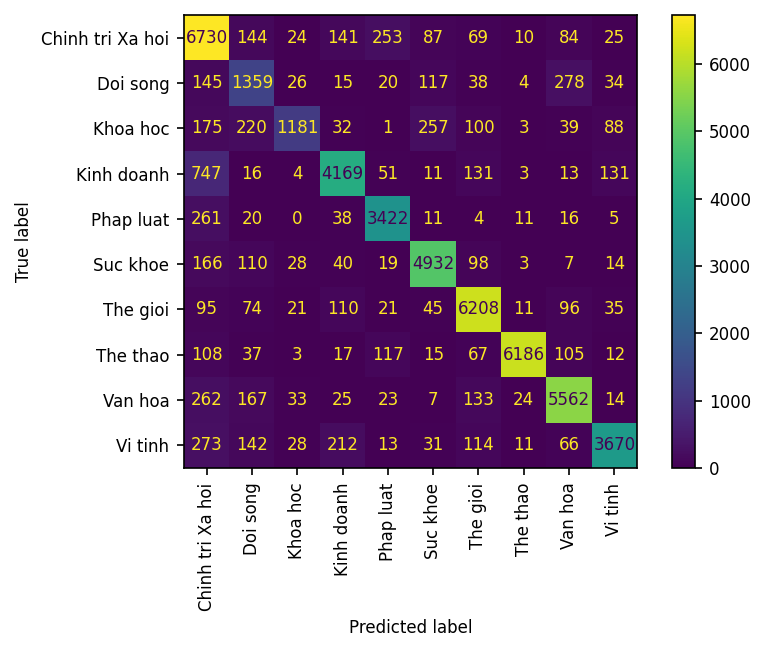

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.75      0.89      0.81      7567
        Doi song       0.59      0.67      0.63      2036
        Khoa hoc       0.88      0.56      0.69      2096
      Kinh doanh       0.87      0.79      0.83      5276
       Phap luat       0.87      0.90      0.89      3788
        Suc khoe       0.89      0.91      0.90      5417
        The gioi       0.89      0.92      0.91      6716
        The thao       0.99      0.93      0.96      6667
         Van hoa       0.89      0.89      0.89      6250
         Vi tinh       0.91      0.80      0.85      4560

        accuracy                           0.86     50373
       macro avg       0.85      0.83      0.84     50373
    weighted avg       0.87      0.86      0.86     50373

Validation accuracy:  0.8601895734597157
Test accuracy:  0.8619498540884998


In [ ]:
from sklearn import naive_bayes
train_model(naive_bayes.MultinomialNB(), X_data_tfidf_ngram, y_data_n, X_test_tfidf_ngram, y_test_n, is_neuralnet=False)

CPU times: user 254 ms, sys: 20.8 ms, total: 275 ms
Wall time: 238 ms


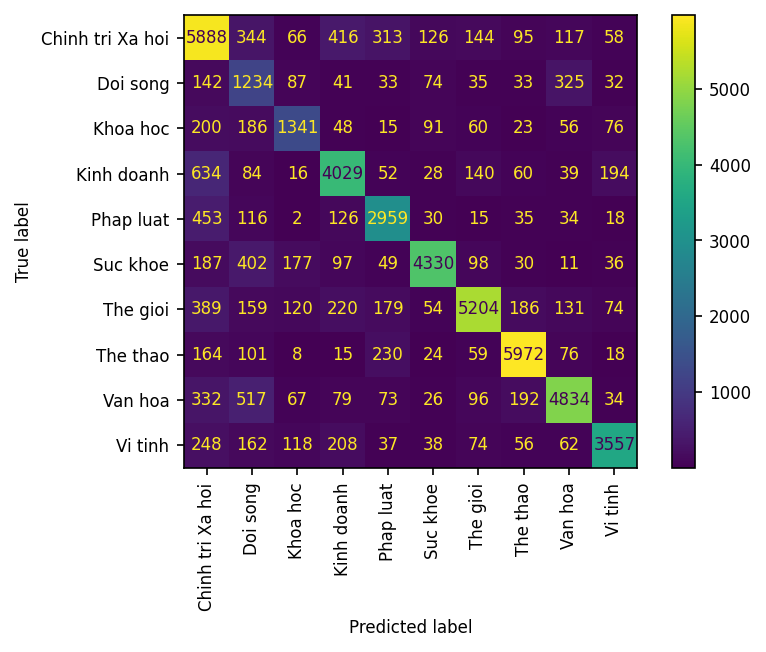

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.68      0.78      0.73      7567
        Doi song       0.37      0.61      0.46      2036
        Khoa hoc       0.67      0.64      0.65      2096
      Kinh doanh       0.76      0.76      0.76      5276
       Phap luat       0.75      0.78      0.77      3788
        Suc khoe       0.90      0.80      0.85      5417
        The gioi       0.88      0.77      0.82      6716
        The thao       0.89      0.90      0.89      6667
         Van hoa       0.85      0.77      0.81      6250
         Vi tinh       0.87      0.78      0.82      4560

        accuracy                           0.78     50373
       macro avg       0.76      0.76      0.76     50373
    weighted avg       0.80      0.78      0.79     50373

Validation accuracy:  0.7710308056872038
Test accuracy:  0.7811327496873325


In [ ]:
from sklearn import naive_bayes
train_model(naive_bayes.BernoulliNB(), X_data_tfidf_ngram_svd, y_data_n, X_test_tfidf_ngram_svd, y_test_n, is_neuralnet=False)

# Linear Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CPU times: user 37.6 s, sys: 27.6 s, total: 1min 5s
Wall time: 36.9 s


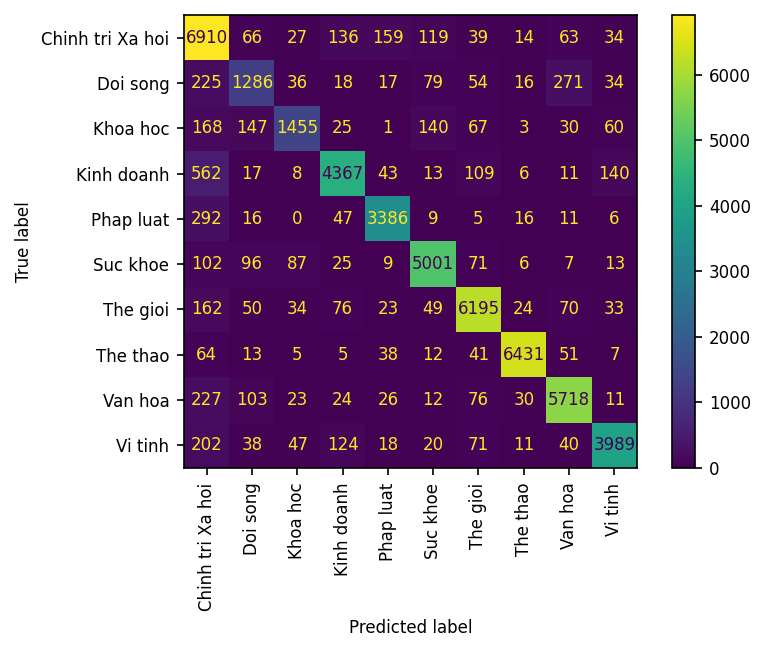

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.78      0.91      0.84      7567
        Doi song       0.70      0.63      0.66      2036
        Khoa hoc       0.84      0.69      0.76      2096
      Kinh doanh       0.90      0.83      0.86      5276
       Phap luat       0.91      0.89      0.90      3788
        Suc khoe       0.92      0.92      0.92      5417
        The gioi       0.92      0.92      0.92      6716
        The thao       0.98      0.96      0.97      6667
         Van hoa       0.91      0.91      0.91      6250
         Vi tinh       0.92      0.87      0.90      4560

        accuracy                           0.89     50373
       macro avg       0.88      0.86      0.87     50373
    weighted avg       0.89      0.89      0.89     50373

Validation accuracy:  0.8918838862559242
Test accuracy:  0.8881345165068588


In [ ]:
from sklearn import linear_model
train_model(linear_model.LogisticRegression(), X_data_tfidf_ngram, y_data_n, X_test_tfidf_ngram, y_test_n, is_neuralnet=False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CPU times: user 16.5 s, sys: 4.03 s, total: 20.6 s
Wall time: 12.1 s


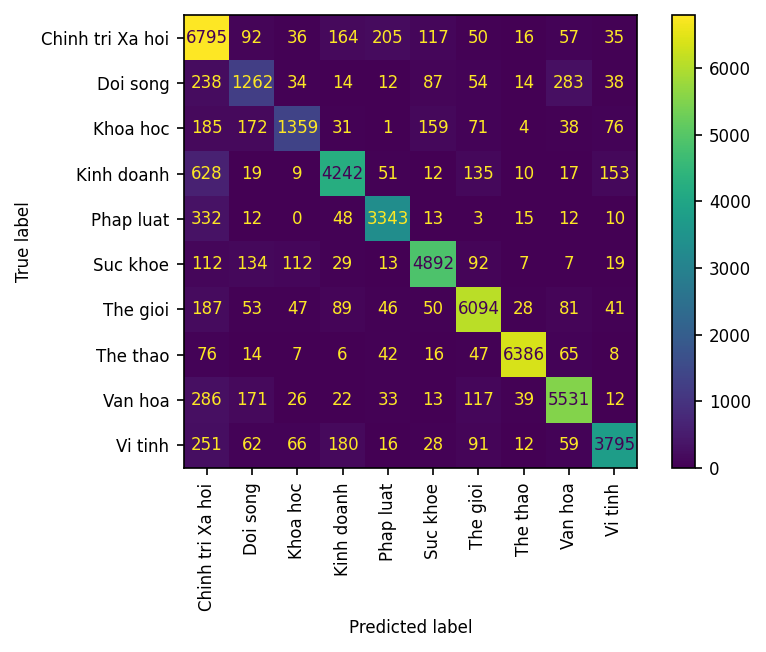

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.75      0.90      0.82      7567
        Doi song       0.63      0.62      0.63      2036
        Khoa hoc       0.80      0.65      0.72      2096
      Kinh doanh       0.88      0.80      0.84      5276
       Phap luat       0.89      0.88      0.89      3788
        Suc khoe       0.91      0.90      0.91      5417
        The gioi       0.90      0.91      0.90      6716
        The thao       0.98      0.96      0.97      6667
         Van hoa       0.90      0.88      0.89      6250
         Vi tinh       0.91      0.83      0.87      4560

        accuracy                           0.87     50373
       macro avg       0.85      0.83      0.84     50373
    weighted avg       0.87      0.87      0.87     50373

Validation accuracy:  0.869372037914692
Test accuracy:  0.8675083874297739


In [ ]:
from sklearn import linear_model
train_model(linear_model.LogisticRegression(), X_data_tfidf_ngram_svd, y_data_n, X_test_tfidf_ngram_svd, y_test_n, is_neuralnet=False)

# Support Vector Machine (SVM)

CPU times: user 25min 21s, sys: 2.66 s, total: 25min 24s
Wall time: 25min 20s


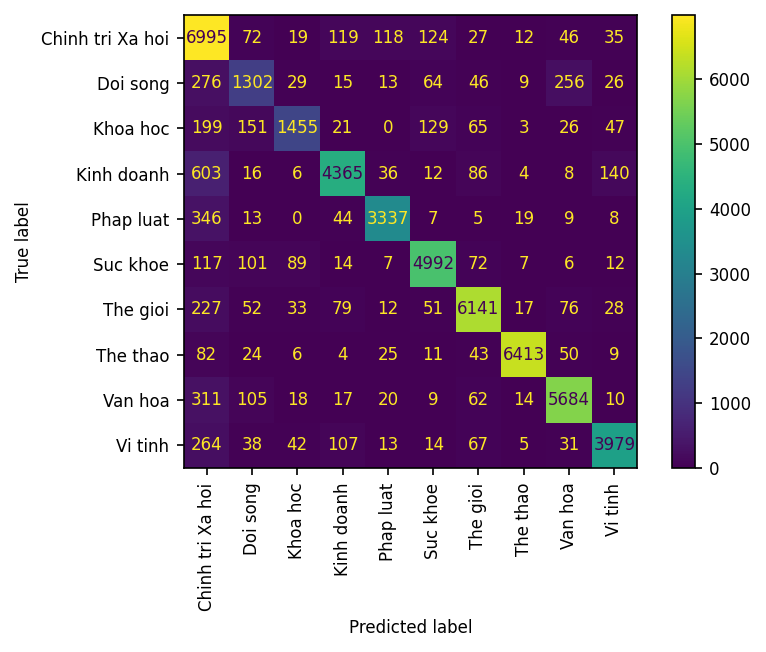

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.74      0.92      0.82      7567
        Doi song       0.69      0.64      0.67      2036
        Khoa hoc       0.86      0.69      0.77      2096
      Kinh doanh       0.91      0.83      0.87      5276
       Phap luat       0.93      0.88      0.91      3788
        Suc khoe       0.92      0.92      0.92      5417
        The gioi       0.93      0.91      0.92      6716
        The thao       0.99      0.96      0.97      6667
         Van hoa       0.92      0.91      0.91      6250
         Vi tinh       0.93      0.87      0.90      4560

        accuracy                           0.89     50373
       macro avg       0.88      0.85      0.87     50373
    weighted avg       0.89      0.89      0.89     50373

Validation accuracy:  0.89010663507109
Test accuracy:  0.886645623647589


In [ ]:
from sklearn import svm
train_model(svm.SVC(), X_data_tfidf_ngram, y_data_n, X_test_tfidf_ngram, y_test_n, is_neuralnet=False)

CPU times: user 2min 5s, sys: 241 ms, total: 2min 5s
Wall time: 2min 5s


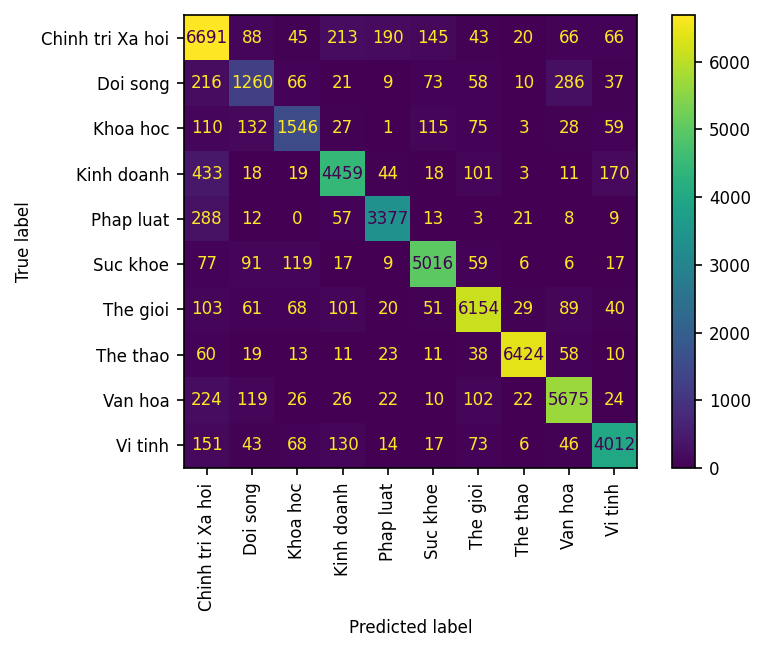

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.80      0.88      0.84      7567
        Doi song       0.68      0.62      0.65      2036
        Khoa hoc       0.78      0.74      0.76      2096
      Kinh doanh       0.88      0.85      0.86      5276
       Phap luat       0.91      0.89      0.90      3788
        Suc khoe       0.92      0.93      0.92      5417
        The gioi       0.92      0.92      0.92      6716
        The thao       0.98      0.96      0.97      6667
         Van hoa       0.90      0.91      0.91      6250
         Vi tinh       0.90      0.88      0.89      4560

        accuracy                           0.89     50373
       macro avg       0.87      0.86      0.86     50373
    weighted avg       0.89      0.89      0.89     50373

Validation accuracy:  0.8918838862559242
Test accuracy:  0.8856728803128661


In [ ]:
from sklearn import svm
train_model(svm.SVC(), X_data_tfidf_ngram_svd, y_data_n, X_test_tfidf_ngram_svd, y_test_n, is_neuralnet=False)

# KNN

with truncatedSVD

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.8 ms


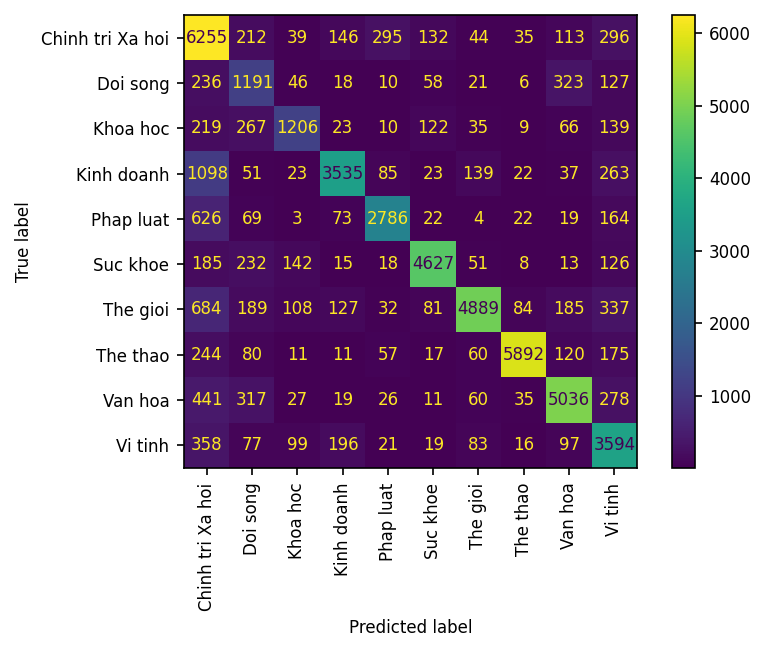

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.60      0.83      0.70      7567
        Doi song       0.44      0.58      0.50      2036
        Khoa hoc       0.71      0.58      0.63      2096
      Kinh doanh       0.85      0.67      0.75      5276
       Phap luat       0.83      0.74      0.78      3788
        Suc khoe       0.91      0.85      0.88      5417
        The gioi       0.91      0.73      0.81      6716
        The thao       0.96      0.88      0.92      6667
         Van hoa       0.84      0.81      0.82      6250
         Vi tinh       0.65      0.79      0.71      4560

        accuracy                           0.77     50373
       macro avg       0.77      0.75      0.75     50373
    weighted avg       0.80      0.77      0.78     50373

Validation accuracy:  0.8009478672985783
Test accuracy:  0.7744426577730134


In [ ]:
from sklearn import neighbors

train_model(neighbors.KNeighborsClassifier(n_neighbors=10, p=2), X_data_tfidf_ngram_svd, y_data_n, X_test_tfidf_ngram_svd, y_test_n, is_neuralnet=False)

Without truncatedSVD


CPU times: user 20.9 ms, sys: 0 ns, total: 20.9 ms
Wall time: 21 ms


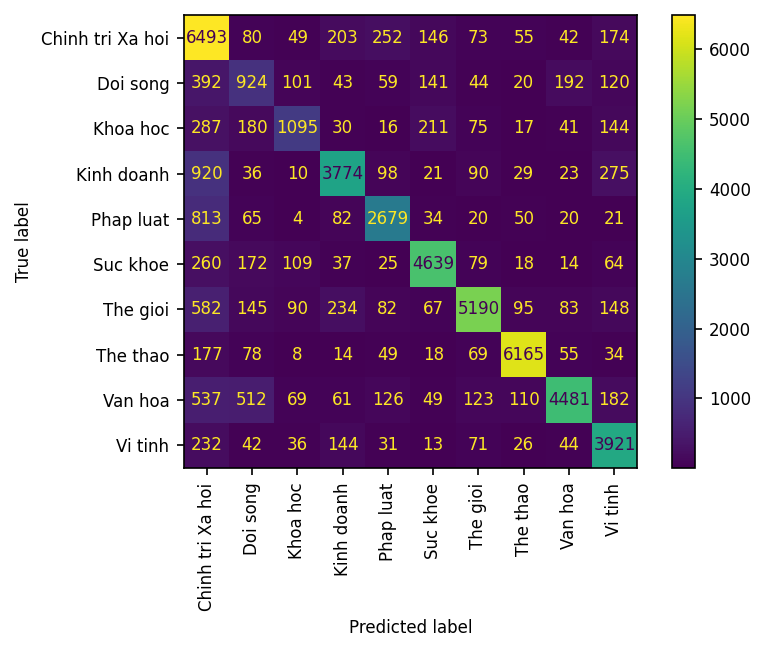

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.61      0.86      0.71      7567
        Doi song       0.41      0.45      0.43      2036
        Khoa hoc       0.70      0.52      0.60      2096
      Kinh doanh       0.82      0.72      0.76      5276
       Phap luat       0.78      0.71      0.74      3788
        Suc khoe       0.87      0.86      0.86      5417
        The gioi       0.89      0.77      0.83      6716
        The thao       0.94      0.92      0.93      6667
         Van hoa       0.90      0.72      0.80      6250
         Vi tinh       0.77      0.86      0.81      4560

        accuracy                           0.78     50373
       macro avg       0.77      0.74      0.75     50373
    weighted avg       0.80      0.78      0.78     50373

Validation accuracy:  0.8018364928909952
Test accuracy:  0.781390824449606


In [ ]:
train_model(neighbors.KNeighborsClassifier(n_neighbors=10, p=2), X_data_tfidf_ngram, y_data_n, X_test_tfidf_ngram, y_test_n, is_neuralnet=False)

# Deep Neural Network (DNN)

In [6]:
from keras.layers import Dense, Input
from keras import models

def create_dnn_model():
    input_layer = Input(shape=(300,))
    layer = Dense(1024, activation='relu')(input_layer)
    layer = Dense(1024, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    output_layer = Dense(10, activation='softmax')(layer)
    
    classifier = models.Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

Epoch 1/50
60/60 [==============================] - 9s 139ms/step - loss: 0.9393 - accuracy: 0.7207 - val_loss: 0.3786 - val_accuracy: 0.8812
Epoch 2/50
60/60 [==============================] - 7s 109ms/step - loss: 0.3549 - accuracy: 0.8823 - val_loss: 0.3647 - val_accuracy: 0.8815
Epoch 3/50
60/60 [==============================] - 7s 111ms/step - loss: 0.3239 - accuracy: 0.8901 - val_loss: 0.3774 - val_accuracy: 0.8765
Epoch 4/50
60/60 [==============================] - 7s 109ms/step - loss: 0.3003 - accuracy: 0.8977 - val_loss: 0.3485 - val_accuracy: 0.8857
Epoch 5/50
60/60 [==============================] - 7s 109ms/step - loss: 0.2802 - accuracy: 0.9038 - val_loss: 0.3711 - val_accuracy: 0.8771
Epoch 6/50
60/60 [==============================] - 7s 112ms/step - loss: 0.2624 - accuracy: 0.9113 - val_loss: 0.3534 - val_accuracy: 0.8860
Epoch 7/50
60/60 [==============================] - 7s 110ms/step - loss: 0.2391 - accuracy: 0.9167 - val_loss: 0.3523 - val_accuracy: 0.8880
Epoch 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


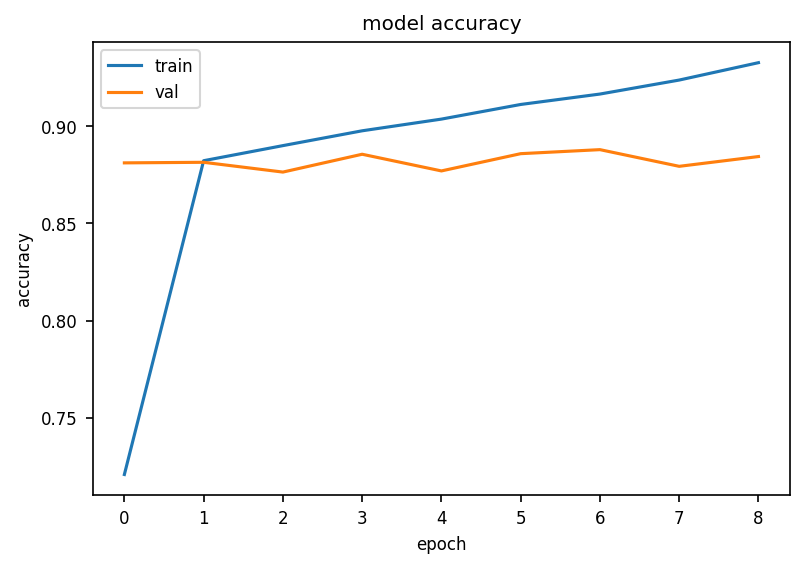

Validation accuracy:  0.884478672985782
Test accuracy:  0.8832112441188732


In [7]:
classifier = create_dnn_model()
train_model(classifier=classifier, X_data=X_data_tfidf_ngram_svd, y_data=y_data_n, X_test=X_test_tfidf_ngram_svd, y_test=y_test_n, is_neuralnet=True)

In [8]:
score = classifier.evaluate(X_test_tfidf_ngram_svd, y_test_n, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.38760292530059814
Test accuracy:  0.8832112550735474


In [9]:
y_pred = classifier.predict(X_test_tfidf_ngram_svd)
print(y_pred)

[[9.2680436e-01 3.3389544e-04 1.1763851e-03 ... 1.1423471e-02
  1.4525066e-03 6.7822328e-03]
 [9.9617356e-01 2.3036534e-06 1.0481403e-05 ... 6.9821131e-06
  7.6647499e-05 8.1415412e-05]
 [4.8979723e-01 1.8563568e-04 2.1153246e-04 ... 1.0436851e-03
  5.0131321e-01 1.8016664e-04]
 ...
 [2.2776142e-06 9.8433611e-06 2.1838814e-06 ... 2.1231792e-05
  6.6653265e-06 9.9994838e-01]
 [1.4589677e-02 4.2180991e-04 1.3115609e-03 ... 2.2270990e-04
  6.8944396e-04 9.6954733e-01]
 [3.1197826e-05 2.7231190e-05 2.9881025e-04 ... 4.5466699e-05
  8.3491133e-05 9.9943739e-01]]


# LSTM - Long-short term memory


In [10]:
from keras.layers import Dense, Input, Reshape, LSTM
from keras import models

def create_lstm_model():
    input_layer = Input(shape=(300,))
    
    layer = Reshape((10, 30))(input_layer)
    layer = LSTM(128, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    
    output_layer = Dense(10, activation='softmax')(layer)
    
    classifier = models.Model(input_layer, output_layer)
    
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

Epoch 1/100
60/60 [==============================] - 9s 121ms/step - loss: 2.1710 - accuracy: 0.1765 - val_loss: 1.9469 - val_accuracy: 0.2236
Epoch 2/100
60/60 [==============================] - 7s 115ms/step - loss: 1.6809 - accuracy: 0.3565 - val_loss: 1.4570 - val_accuracy: 0.4449
Epoch 3/100
60/60 [==============================] - 7s 120ms/step - loss: 1.3951 - accuracy: 0.4659 - val_loss: 1.3010 - val_accuracy: 0.4899
Epoch 4/100
60/60 [==============================] - 7s 113ms/step - loss: 1.3001 - accuracy: 0.4973 - val_loss: 1.2691 - val_accuracy: 0.5113
Epoch 5/100
60/60 [==============================] - 7s 117ms/step - loss: 1.2359 - accuracy: 0.5392 - val_loss: 1.1837 - val_accuracy: 0.5619
Epoch 6/100
60/60 [==============================] - 7s 110ms/step - loss: 1.1735 - accuracy: 0.5747 - val_loss: 1.1615 - val_accuracy: 0.5735
Epoch 7/100
60/60 [==============================] - 7s 111ms/step - loss: 1.1381 - accuracy: 0.5910 - val_loss: 1.0754 - val_accuracy: 0.6203

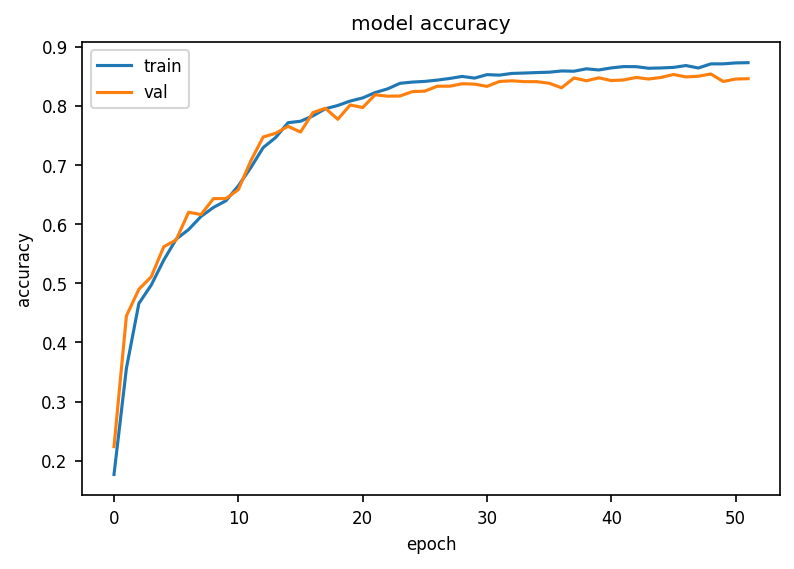

Validation accuracy:  0.8462677725118484
Test accuracy:  0.8492644869275207


In [11]:
classifier = create_lstm_model()
train_model(classifier=classifier, X_data=X_data_tfidf_ngram_svd, y_data=y_data_n, X_test=X_test_tfidf_ngram_svd, y_test=y_test_n, is_neuralnet=True, n_epochs=100)

In [12]:
score = classifier.evaluate(X_test_tfidf_ngram_svd, y_test_n, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.49804583191871643
Test accuracy:  0.8492645025253296


In [13]:
y_pred = classifier.predict(X_test_tfidf_ngram_svd)
print(y_pred)

[[8.3940059e-01 8.8986685e-04 3.1465397e-03 ... 1.1674997e-03
  8.4148813e-04 5.7173562e-03]
 [9.1773570e-01 2.5143474e-04 2.2769945e-03 ... 3.7705537e-04
  1.5513656e-04 2.4434267e-02]
 [9.7273082e-01 6.3817884e-04 1.6329238e-03 ... 8.9058082e-04
  1.5732163e-03 1.3047541e-03]
 ...
 [5.0781104e-03 4.2043887e-03 7.2979461e-03 ... 1.1367389e-03
  5.8709725e-04 9.5679814e-01]
 [6.9783902e-01 1.1659814e-02 4.6100155e-02 ... 1.3578662e-02
  1.2208938e-02 9.9436633e-02]
 [1.1661482e-03 1.1917381e-03 1.4956356e-03 ... 2.5588140e-04
  1.4765533e-04 9.8988461e-01]]


# Doc2Vec


In [14]:
from tqdm import tqdm
import gensim

def get_corpus(documents):
    corpus = []
    
    for i in tqdm(range(len(documents))):
        doc = documents[i]
        
        words = doc.split(' ')
        tagged_document = gensim.models.doc2vec.TaggedDocument(words, [i])
        
        corpus.append(tagged_document)
        
    return corpus
    
train_corpus = get_corpus(X_data)
test_corpus = get_corpus(X_test)

100%|██████████| 50373/50373 [00:05<00:00, 8865.89it/s] 


In [15]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=40)
model.build_vocab(train_corpus)

%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 34min 52s, sys: 22.3 s, total: 35min 14s
Wall time: 18min 55s


In [16]:
model.save('/content/drive/MyDrive/XLNNTN/doc2vec')

In [17]:
model = gensim.models.doc2vec.Doc2Vec.load('/content/drive/MyDrive/XLNNTN/doc2vec')

In [18]:
X_data_vectors = []
for x in train_corpus:
    vector = model.infer_vector(x.words)
    X_data_vectors.append(vector)
    
X_test_vectors = []
for x in test_corpus:
    vector = model.infer_vector(x.words)
    X_test_vectors.append(vector)

In [19]:
pickle.dump(X_data_vectors, open('/content/drive/MyDrive/XLNNTN/X_data_vectors.pkl', 'wb'))
pickle.dump(X_test_vectors, open('/content/drive/MyDrive/XLNNTN/X_test_vectors.pkl', 'wb'))

In [ ]:
X_data_vector = pickle.load(open('/content/drive/MyDrive/XLNNTN/X_data_vectors.pkl', 'rb'))
X_test_vector = pickle.load(open('/content/drive/MyDrive/XLNNTN/X_test_vectors.pkl', 'rb'))

# Deep Neural Network (DNN)

In [20]:
from keras.layers import Dense, Input
from keras import models

def create_dnn_model():
    input_layer = Input(shape=(300,))
    layer = Dense(1024, activation='relu')(input_layer)
    layer = Dense(1024, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    output_layer = Dense(10, activation='softmax')(layer)
    
    classifier = models.Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

Epoch 1/50
60/60 [==============================] - 7s 106ms/step - loss: 0.6404 - accuracy: 0.7972 - val_loss: 0.3736 - val_accuracy: 0.8765
Epoch 2/50
60/60 [==============================] - 6s 104ms/step - loss: 0.2593 - accuracy: 0.9142 - val_loss: 0.3548 - val_accuracy: 0.8854
Epoch 3/50
60/60 [==============================] - 6s 105ms/step - loss: 0.1714 - accuracy: 0.9446 - val_loss: 0.3634 - val_accuracy: 0.8940
Epoch 4/50
60/60 [==============================] - 6s 105ms/step - loss: 0.0992 - accuracy: 0.9688 - val_loss: 0.3979 - val_accuracy: 0.8901
Epoch 5/50
60/60 [==============================] - 6s 105ms/step - loss: 0.0554 - accuracy: 0.9856 - val_loss: 0.4693 - val_accuracy: 0.8868
Epoch 6/50
60/60 [==============================] - 6s 104ms/step - loss: 0.0301 - accuracy: 0.9937 - val_loss: 0.5074 - val_accuracy: 0.8863
Epoch 7/50
60/60 [==============================] - 6s 105ms/step - loss: 0.0231 - accuracy: 0.9956 - val_loss: 0.5558 - val_accuracy: 0.8815


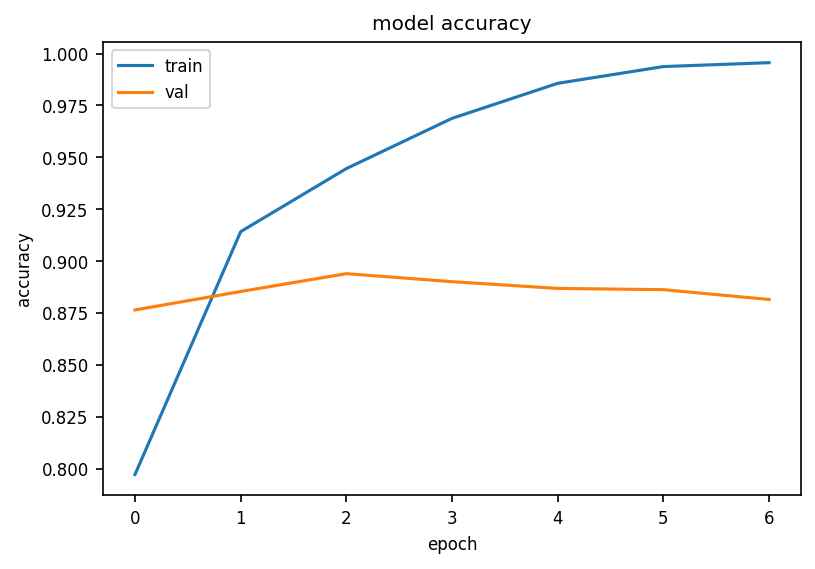

Validation accuracy:  0.8815165876777251
Test accuracy:  0.8673098683818712
CPU times: user 1min 32s, sys: 1.63 s, total: 1min 33s
Wall time: 1min 29s


In [21]:
import numpy as np

classifier = create_dnn_model()
%time train_model(classifier=classifier, X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=True)

In [22]:
score = classifier.evaluate(np.array(X_test_vectors), y_test_n, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.7254815697669983
Test accuracy:  0.8673098683357239


In [23]:
y_pred = classifier.predict(np.array(X_test_vectors))
print(y_pred)

[[8.8927770e-01 3.1590678e-06 2.2426520e-03 ... 1.6177125e-06
  6.2717847e-03 8.9845341e-03]
 [9.9999940e-01 1.0061758e-14 8.1812765e-11 ... 2.0339543e-14
  2.5654659e-11 5.7180029e-07]
 [9.9990487e-01 1.1447990e-08 5.6249196e-09 ... 5.8395249e-06
  5.4567831e-06 2.5506237e-09]
 ...
 [2.3002473e-09 2.8697739e-08 4.8137077e-09 ... 6.1230652e-12
  2.8772279e-08 1.0000000e+00]
 [3.0409620e-04 3.3722904e-06 2.7880127e-05 ... 1.1947078e-07
  4.3026257e-06 9.9889058e-01]
 [4.6467663e-10 2.5741445e-10 1.9425756e-06 ... 1.4211869e-14
  8.6239973e-11 9.9999809e-01]]


# Long-short Term Memory (LSTM)

In [24]:
from keras.layers import Dense, Input, Reshape, LSTM
from keras import models

def create_lstm_model():
    input_layer = Input(shape=(300,))
    
    layer = Reshape((10, 30))(input_layer)
    layer = LSTM(128, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    
    output_layer = Dense(10, activation='softmax')(layer)
    
    classifier = models.Model(input_layer, output_layer)
    
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

Epoch 1/100
60/60 [==============================] - 7s 99ms/step - loss: 1.5795 - accuracy: 0.4604 - val_loss: 1.0929 - val_accuracy: 0.6460
Epoch 2/100
60/60 [==============================] - 7s 122ms/step - loss: 0.9297 - accuracy: 0.6944 - val_loss: 0.8676 - val_accuracy: 0.7195
Epoch 3/100
60/60 [==============================] - 6s 95ms/step - loss: 0.7588 - accuracy: 0.7455 - val_loss: 0.8046 - val_accuracy: 0.7328
Epoch 4/100
60/60 [==============================] - 6s 94ms/step - loss: 0.6489 - accuracy: 0.7813 - val_loss: 0.6434 - val_accuracy: 0.7906
Epoch 5/100
60/60 [==============================] - 6s 94ms/step - loss: 0.5695 - accuracy: 0.8080 - val_loss: 0.5967 - val_accuracy: 0.8066
Epoch 6/100
60/60 [==============================] - 6s 95ms/step - loss: 0.5206 - accuracy: 0.8224 - val_loss: 0.5979 - val_accuracy: 0.8030
Epoch 7/100
60/60 [==============================] - 6s 94ms/step - loss: 0.4806 - accuracy: 0.8370 - val_loss: 0.5722 - val_accuracy: 0.8149
Epoch

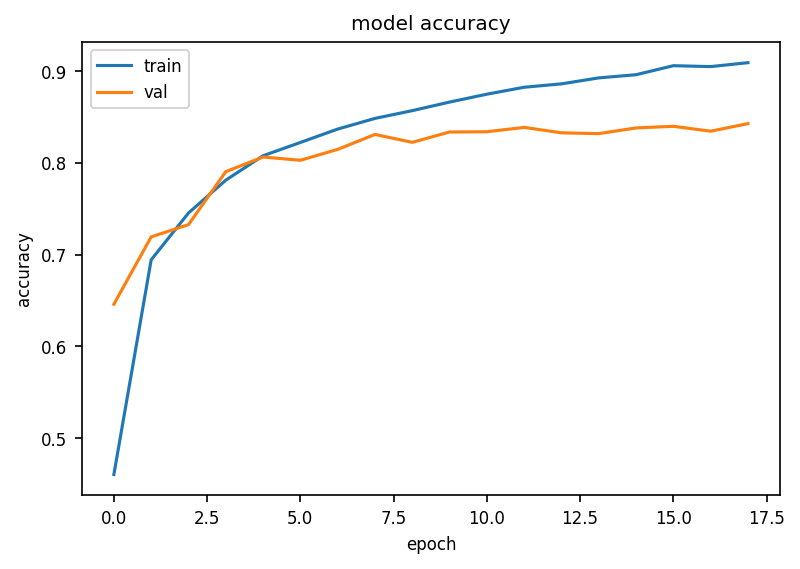

Validation accuracy:  0.8430094786729858
Test accuracy:  0.8119627578266134
CPU times: user 3min 10s, sys: 8.31 s, total: 3min 18s
Wall time: 2min 34s


In [26]:
classifier = create_lstm_model()
%time train_model(classifier=classifier, X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=True, n_epochs=100)

In [27]:
score = classifier.evaluate(np.array(X_test_vectors), y_test_n, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.6790822744369507
Test accuracy:  0.8119627833366394


In [28]:
y_pred = classifier.predict(np.array(X_test_vectors))
print(y_pred)

[[8.64858150e-01 1.28184259e-03 6.20850772e-02 ... 3.67096649e-03
  1.19590713e-02 1.98501348e-02]
 [9.95549083e-01 3.57755766e-06 5.76762286e-05 ... 2.81081429e-06
  5.67273491e-06 5.44666662e-04]
 [9.62668240e-01 1.04506898e-06 2.78318248e-06 ... 3.89453780e-05
  2.32382554e-05 6.41494182e-07]
 ...
 [2.84547459e-05 5.62314017e-06 5.25726027e-05 ... 1.88816045e-07
  5.50517279e-06 9.99884486e-01]
 [7.54501112e-03 8.20197019e-05 5.08426572e-04 ... 9.46150976e-05
  7.07068903e-05 9.88649607e-01]
 [9.63296508e-04 1.24096579e-04 1.42047361e-01 ... 1.18394026e-04
  2.41555599e-03 8.53990793e-01]]


# Naive Bayes

CPU times: user 231 ms, sys: 51.2 ms, total: 283 ms
Wall time: 263 ms


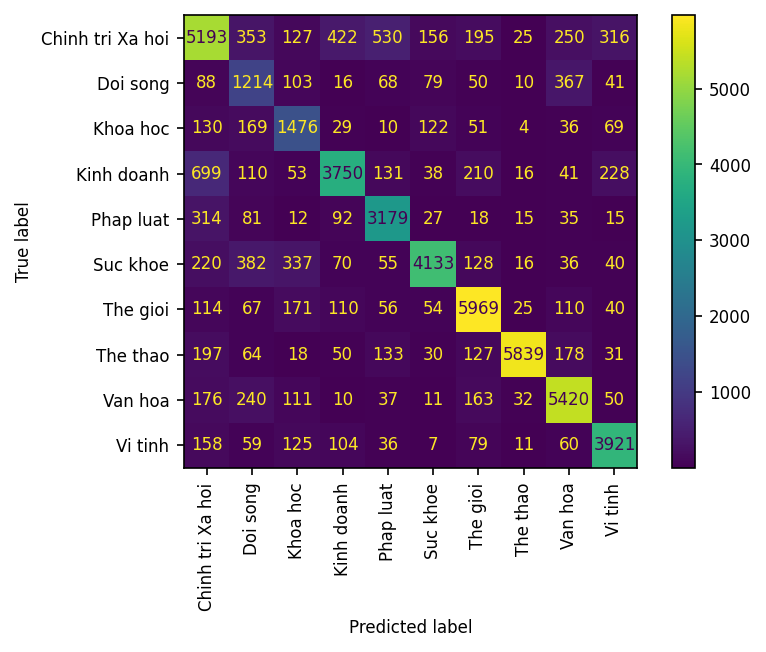

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.71      0.69      0.70      7567
        Doi song       0.44      0.60      0.51      2036
        Khoa hoc       0.58      0.70      0.64      2096
      Kinh doanh       0.81      0.71      0.76      5276
       Phap luat       0.75      0.84      0.79      3788
        Suc khoe       0.89      0.76      0.82      5417
        The gioi       0.85      0.89      0.87      6716
        The thao       0.97      0.88      0.92      6667
         Van hoa       0.83      0.87      0.85      6250
         Vi tinh       0.83      0.86      0.84      4560

        accuracy                           0.80     50373
       macro avg       0.77      0.78      0.77     50373
    weighted avg       0.81      0.80      0.80     50373

Validation accuracy:  0.8003554502369669
Test accuracy:  0.7959422706608699


In [29]:
from sklearn import naive_bayes
train_model(naive_bayes.BernoulliNB(), X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=False)

# Linear Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CPU times: user 14 s, sys: 3.11 s, total: 17.1 s
Wall time: 8.79 s


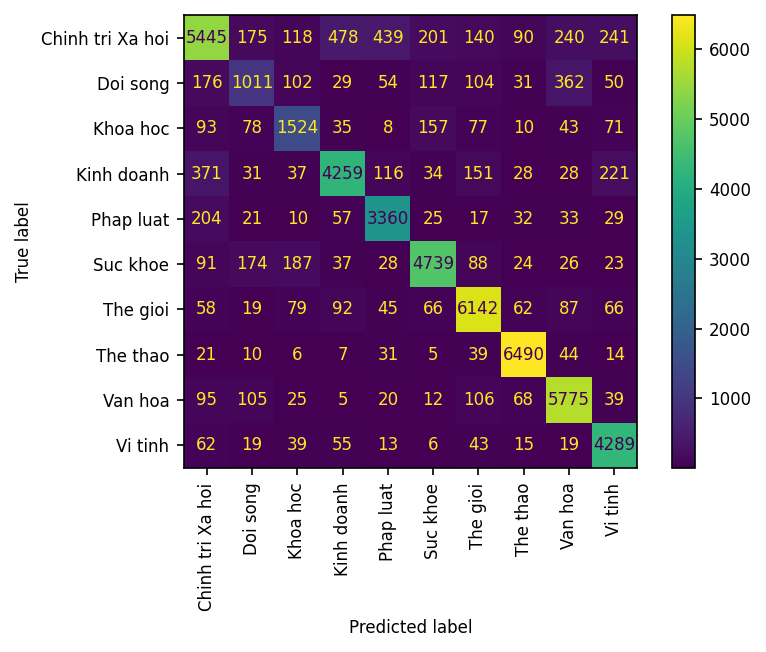

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.82      0.72      0.77      7567
        Doi song       0.62      0.50      0.55      2036
        Khoa hoc       0.72      0.73      0.72      2096
      Kinh doanh       0.84      0.81      0.82      5276
       Phap luat       0.82      0.89      0.85      3788
        Suc khoe       0.88      0.87      0.88      5417
        The gioi       0.89      0.91      0.90      6716
        The thao       0.95      0.97      0.96      6667
         Van hoa       0.87      0.92      0.89      6250
         Vi tinh       0.85      0.94      0.89      4560

        accuracy                           0.85     50373
       macro avg       0.83      0.83      0.82     50373
    weighted avg       0.85      0.85      0.85     50373

Validation accuracy:  0.8770734597156398
Test accuracy:  0.8543068707442479


In [30]:
from sklearn import linear_model
train_model(linear_model.LogisticRegression(), X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=False)

# Support Vector Machine (SVM)

CPU times: user 1min 17s, sys: 209 ms, total: 1min 18s
Wall time: 1min 17s


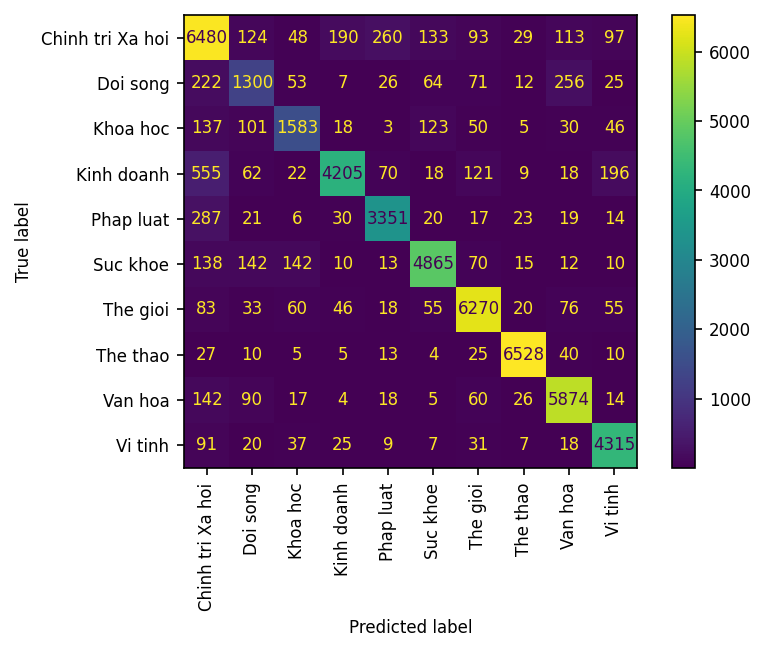

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.79      0.86      0.82      7567
        Doi song       0.68      0.64      0.66      2036
        Khoa hoc       0.80      0.76      0.78      2096
      Kinh doanh       0.93      0.80      0.86      5276
       Phap luat       0.89      0.88      0.89      3788
        Suc khoe       0.92      0.90      0.91      5417
        The gioi       0.92      0.93      0.93      6716
        The thao       0.98      0.98      0.98      6667
         Van hoa       0.91      0.94      0.92      6250
         Vi tinh       0.90      0.95      0.92      4560

        accuracy                           0.89     50373
       macro avg       0.87      0.86      0.87     50373
    weighted avg       0.89      0.89      0.89     50373

Validation accuracy:  0.9034360189573459
Test accuracy:  0.8887896293649376


In [31]:
from sklearn import svm
train_model(svm.SVC(), X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=False)

# KNN

k = 10

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.8 ms


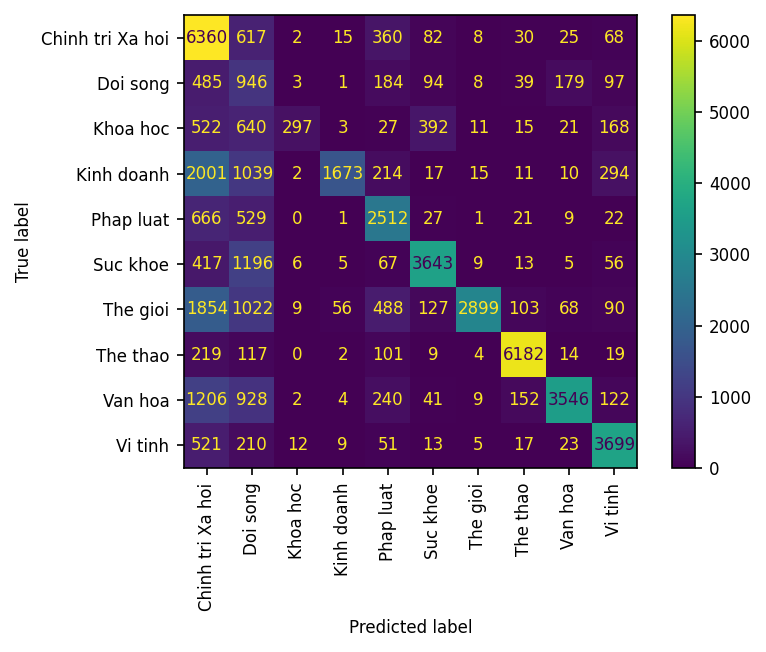

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.45      0.84      0.58      7567
        Doi song       0.13      0.46      0.20      2036
        Khoa hoc       0.89      0.14      0.24      2096
      Kinh doanh       0.95      0.32      0.47      5276
       Phap luat       0.59      0.66      0.63      3788
        Suc khoe       0.82      0.67      0.74      5417
        The gioi       0.98      0.43      0.60      6716
        The thao       0.94      0.93      0.93      6667
         Van hoa       0.91      0.57      0.70      6250
         Vi tinh       0.80      0.81      0.80      4560

        accuracy                           0.63     50373
       macro avg       0.74      0.58      0.59     50373
    weighted avg       0.78      0.63      0.65     50373

Validation accuracy:  0.5986374407582938
Test accuracy:  0.6304369404244338


In [32]:
from sklearn import neighbors

train_model(neighbors.KNeighborsClassifier(n_neighbors=10, p=2), X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=False)

# 3 TOPIC

# 3 topic processing

In [ ]:
!git clone https://github.com/duyvuleo/VNTC/

In [ ]:
!pip install pyvi

In [ ]:
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP

In [ ]:
!unrar x "/content/VNTC/Data/10Topics/Ver1.1/Test_Full.rar"
!unrar x "/content/VNTC/Data/10Topics/Ver1.1/Train_Full.rar"

In [ ]:
!rm -r '/content/Test_Full/Doi song'
!rm -r '/content/Test_Full/Phap luat'
!rm -r '/content/Test_Full/Suc khoe'
!rm -r '/content/Test_Full/Khoa hoc'
!rm -r '/content/Test_Full/The thao'
!rm -r '/content/Test_Full/Vi tinh'
!rm -r '/content/Test_Full/Chinh tri Xa hoi'

In [ ]:
!rm -r '/content/Train_Full/Doi song'
!rm -r '/content/Train_Full/Phap luat'
!rm -r '/content/Train_Full/Suc khoe'
!rm -r '/content/Train_Full/Khoa hoc'
!rm -r '/content/Train_Full/The thao'
!rm -r '/content/Train_Full/Vi tinh'
!rm -r '/content/Train_Full/Chinh tri Xa hoi'

In [ ]:
import os
dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
dir_path = os.path.join(dir_path, 'Data')

train_path = os.path.join(dir_path, '/content/Train_Full')
X_data, y_data = get_data(train_path)
test_path = os.path.join(dir_path, '/content/Test_Full')
X_test, y_test = get_data(test_path)

In [ ]:
import pickle

pickle.dump(X_data, open('/content/drive/MyDrive/XLNNTN/X_data_3topic.pkl', 'wb'))
pickle.dump(y_data, open('/content/drive/MyDrive/XLNNTN/y_data_3topic.pkl', 'wb'))
pickle.dump(X_test, open('/content/drive/MyDrive/XLNNTN/X_test_3topic.pkl', 'wb'))
pickle.dump(y_test, open('/content/drive/MyDrive/XLNNTN/y_test_3topic.pkl', 'wb'))

In [33]:
import pickle
X_data_3topic = pickle.load(open('/content/drive/MyDrive/XLNNTN/X_data_3topic.pkl', 'rb'))
y_data_3topic = pickle.load(open('/content/drive/MyDrive/XLNNTN/y_data_3topic.pkl', 'rb'))
X_test_3topic = pickle.load(open('/content/drive/MyDrive/XLNNTN/X_test_3topic.pkl', 'rb'))
y_test_3topic = pickle.load(open('/content/drive/MyDrive/XLNNTN/y_test_3topic.pkl', 'rb'))

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
# ngram level - we choose max number of words equal to 30000 except all words (100k+ words)
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', max_features=30000, ngram_range=(2, 3))
tfidf_vect_ngram.fit(X_data_3topic)
X_data_tfidf_ngram =  tfidf_vect_ngram.transform(X_data_3topic)
# assume that we don't have test set before
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test_3topic)

In [35]:
from sklearn.decomposition import TruncatedSVD

svd_ngram = TruncatedSVD(n_components=300, random_state=42)
svd_ngram.fit(X_data_tfidf_ngram)

X_data_tfidf_ngram_svd = svd_ngram.transform(X_data_tfidf_ngram)
X_test_tfidf_ngram_svd = svd_ngram.transform(X_test_tfidf_ngram)

In [39]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
y_data_n = encoder.fit_transform(y_data_3topic)
y_test_n = encoder.fit_transform(y_test_3topic)

encoder.classes_

array(['Kinh doanh', 'The gioi', 'Van hoa'], dtype='<U10')

# Naive Bayes

CPU times: user 15.1 ms, sys: 979 µs, total: 16.1 ms
Wall time: 16.1 ms


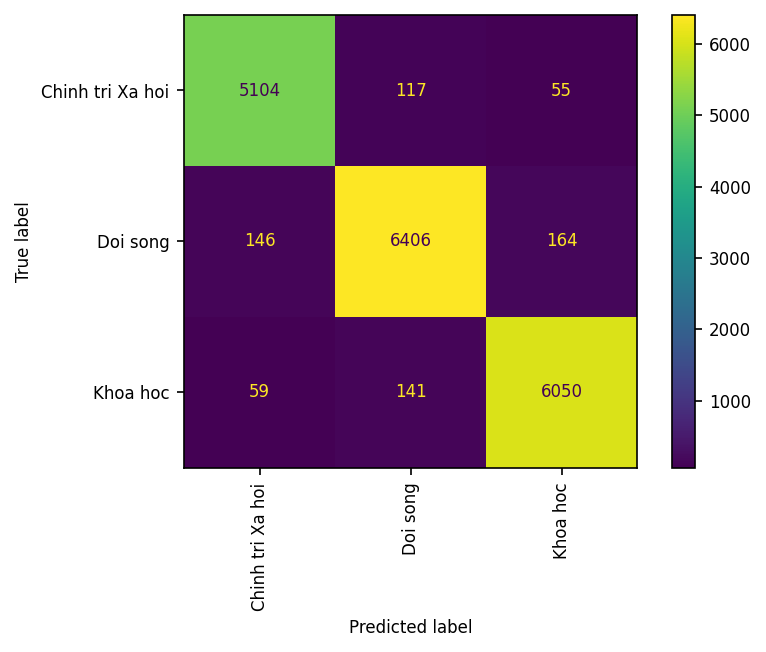

              precision    recall  f1-score   support

  Kinh doanh       0.96      0.97      0.96      5276
    The gioi       0.96      0.95      0.96      6716
     Van hoa       0.97      0.97      0.97      6250

    accuracy                           0.96     18242
   macro avg       0.96      0.96      0.96     18242
weighted avg       0.96      0.96      0.96     18242

Validation accuracy:  0.9542790152403282
Test accuracy:  0.9626137484924898


In [40]:
from sklearn import naive_bayes
train_model(naive_bayes.MultinomialNB(), X_data_tfidf_ngram, y_data_n, X_test_tfidf_ngram, y_test_n, is_neuralnet=False)

CPU times: user 54.4 ms, sys: 985 µs, total: 55.4 ms
Wall time: 51.5 ms


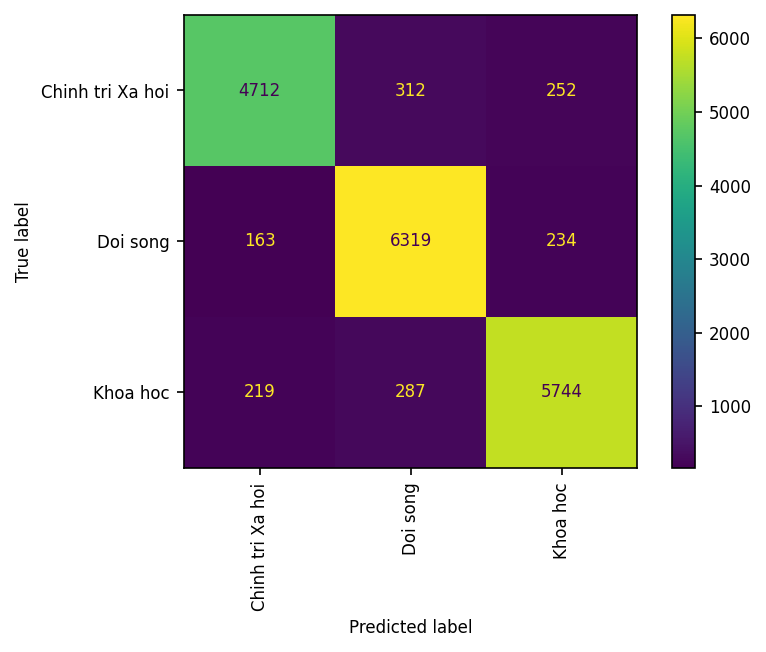

              precision    recall  f1-score   support

  Kinh doanh       0.93      0.89      0.91      5276
    The gioi       0.91      0.94      0.93      6716
     Van hoa       0.92      0.92      0.92      6250

    accuracy                           0.92     18242
   macro avg       0.92      0.92      0.92     18242
weighted avg       0.92      0.92      0.92     18242

Validation accuracy:  0.9050410316529894
Test accuracy:  0.9195811862734349


In [41]:
from sklearn import naive_bayes
train_model(naive_bayes.BernoulliNB(), X_data_tfidf_ngram_svd, y_data_n, X_test_tfidf_ngram_svd, y_test_n, is_neuralnet=False)

# Linear Classifier

CPU times: user 4.97 s, sys: 5.22 s, total: 10.2 s
Wall time: 5.28 s


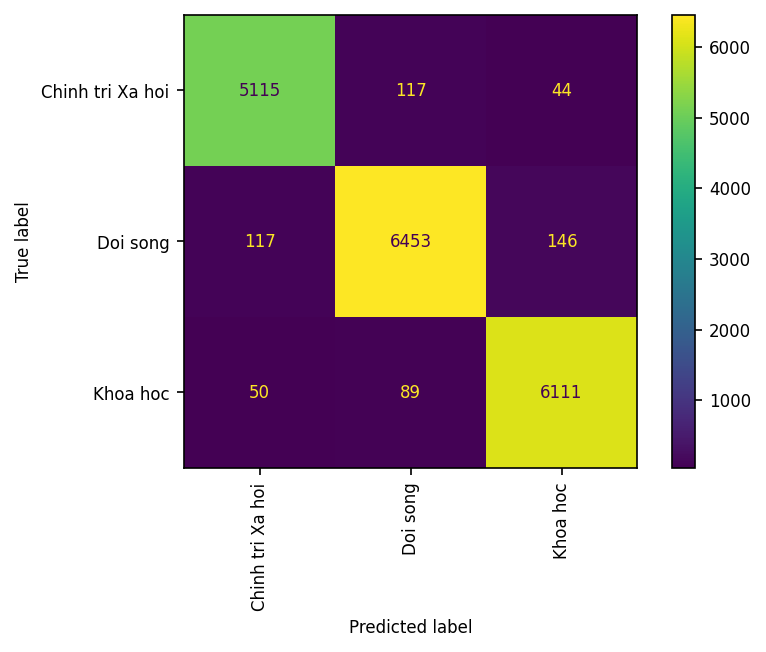

              precision    recall  f1-score   support

  Kinh doanh       0.97      0.97      0.97      5276
    The gioi       0.97      0.96      0.96      6716
     Van hoa       0.97      0.98      0.97      6250

    accuracy                           0.97     18242
   macro avg       0.97      0.97      0.97     18242
weighted avg       0.97      0.97      0.97     18242

Validation accuracy:  0.9636576787807737
Test accuracy:  0.969137156013595


In [42]:
from sklearn import linear_model
train_model(linear_model.LogisticRegression(), X_data_tfidf_ngram, y_data_n, X_test_tfidf_ngram, y_test_n, is_neuralnet=False)

CPU times: user 1.07 s, sys: 275 ms, total: 1.34 s
Wall time: 717 ms


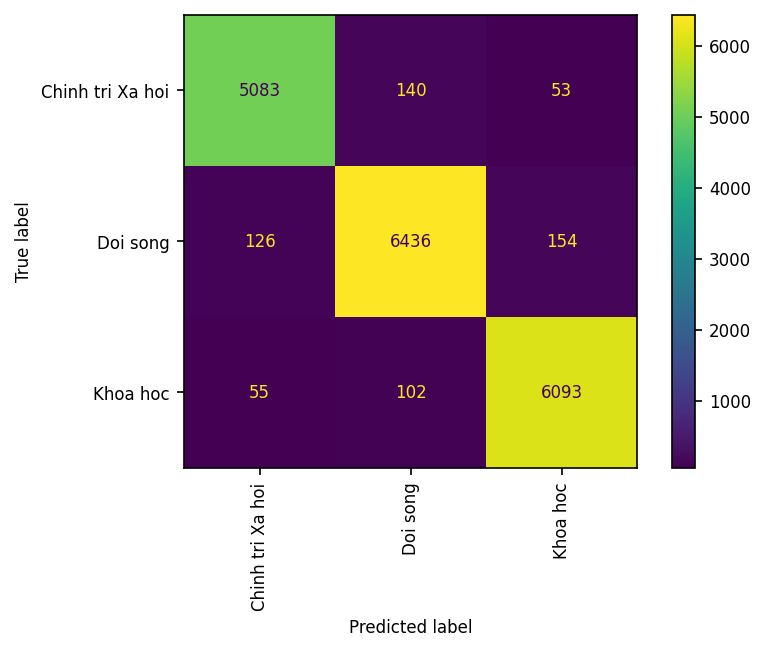

              precision    recall  f1-score   support

  Kinh doanh       0.97      0.96      0.96      5276
    The gioi       0.96      0.96      0.96      6716
     Van hoa       0.97      0.97      0.97      6250

    accuracy                           0.97     18242
   macro avg       0.97      0.97      0.97     18242
weighted avg       0.97      0.97      0.97     18242

Validation accuracy:  0.9601406799531067
Test accuracy:  0.965464313123561


In [43]:
from sklearn import linear_model
train_model(linear_model.LogisticRegression(), X_data_tfidf_ngram_svd, y_data_n, X_test_tfidf_ngram_svd, y_test_n, is_neuralnet=False)

# Support Vector Machine (SVM)

CPU times: user 1min 38s, sys: 133 ms, total: 1min 38s
Wall time: 1min 41s


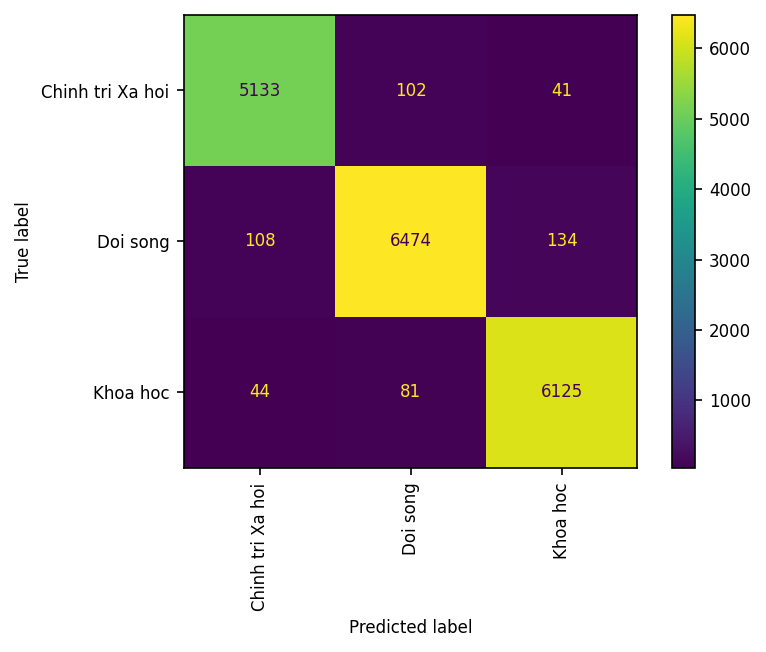

              precision    recall  f1-score   support

  Kinh doanh       0.97      0.97      0.97      5276
    The gioi       0.97      0.96      0.97      6716
     Van hoa       0.97      0.98      0.98      6250

    accuracy                           0.97     18242
   macro avg       0.97      0.97      0.97     18242
weighted avg       0.97      0.97      0.97     18242

Validation accuracy:  0.9683470105509965
Test accuracy:  0.9720425391952636


In [44]:
from sklearn import svm
train_model(svm.SVC(), X_data_tfidf_ngram, y_data_n, X_test_tfidf_ngram, y_test_n, is_neuralnet=False)

CPU times: user 3.46 s, sys: 15.7 ms, total: 3.47 s
Wall time: 3.46 s


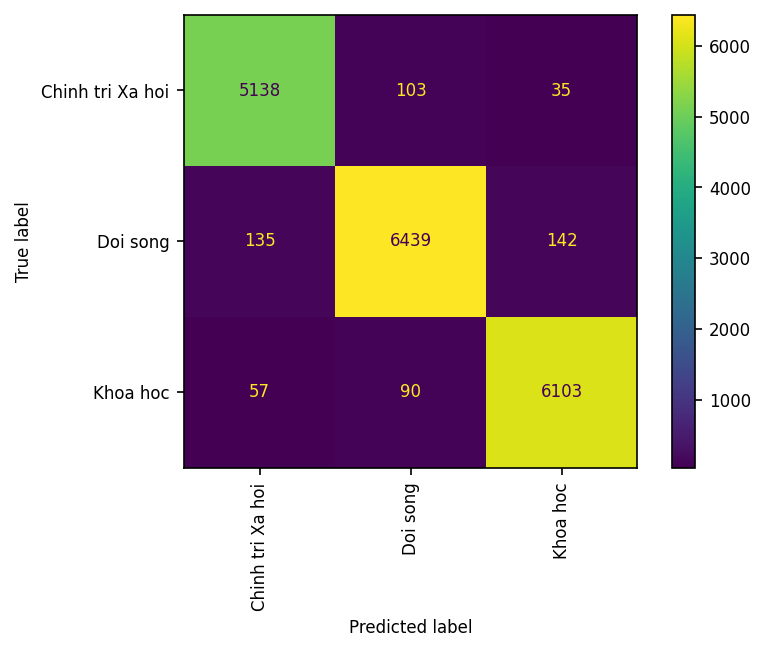

              precision    recall  f1-score   support

  Kinh doanh       0.96      0.97      0.97      5276
    The gioi       0.97      0.96      0.96      6716
     Van hoa       0.97      0.98      0.97      6250

    accuracy                           0.97     18242
   macro avg       0.97      0.97      0.97     18242
weighted avg       0.97      0.97      0.97     18242

Validation accuracy:  0.9671746776084408
Test accuracy:  0.9691919745641925


In [45]:
from sklearn import svm
train_model(svm.SVC(), X_data_tfidf_ngram_svd, y_data_n, X_test_tfidf_ngram_svd, y_test_n, is_neuralnet=False)

# KNN

with truncatedSVD

CPU times: user 2.7 ms, sys: 15 µs, total: 2.72 ms
Wall time: 2.73 ms


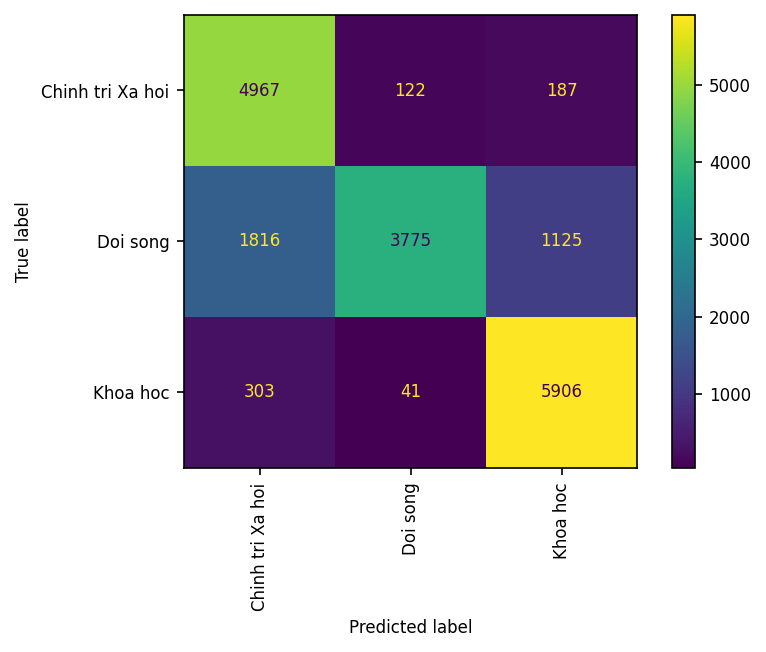

              precision    recall  f1-score   support

  Kinh doanh       0.70      0.94      0.80      5276
    The gioi       0.96      0.56      0.71      6716
     Van hoa       0.82      0.94      0.88      6250

    accuracy                           0.80     18242
   macro avg       0.83      0.82      0.80     18242
weighted avg       0.84      0.80      0.79     18242

Validation accuracy:  0.8827667057444314
Test accuracy:  0.8029821291525052


In [46]:
from sklearn import neighbors

train_model(neighbors.KNeighborsClassifier(n_neighbors=3, p=2), X_data_tfidf_ngram_svd, y_data_n, X_test_tfidf_ngram_svd, y_test_n, is_neuralnet=False)

Without truncatedSVD


CPU times: user 7.1 ms, sys: 0 ns, total: 7.1 ms
Wall time: 7.08 ms


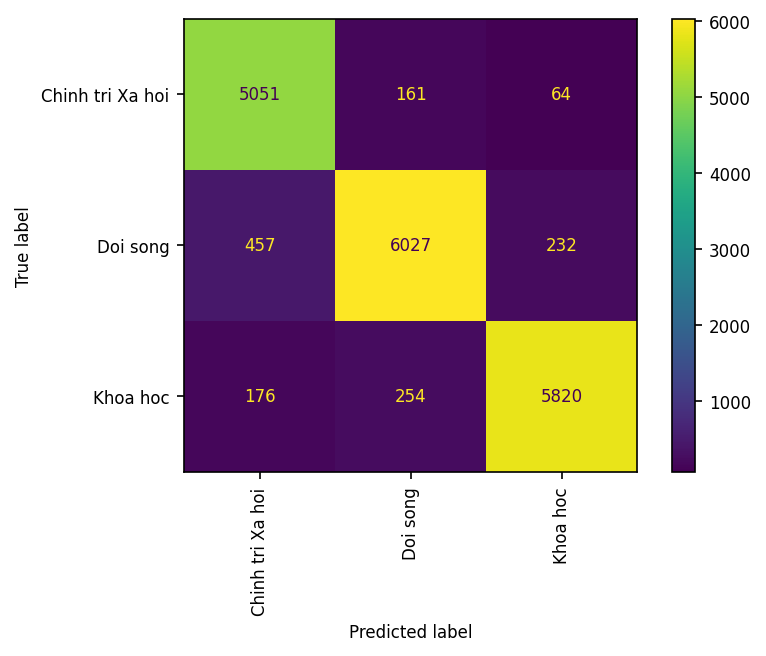

              precision    recall  f1-score   support

  Kinh doanh       0.89      0.96      0.92      5276
    The gioi       0.94      0.90      0.92      6716
     Van hoa       0.95      0.93      0.94      6250

    accuracy                           0.93     18242
   macro avg       0.93      0.93      0.93     18242
weighted avg       0.93      0.93      0.93     18242

Validation accuracy:  0.94021101992966
Test accuracy:  0.9263238679969301


In [47]:
train_model(neighbors.KNeighborsClassifier(n_neighbors=3, p=2), X_data_tfidf_ngram, y_data_n, X_test_tfidf_ngram, y_test_n, is_neuralnet=False)

# Deep Neural Network (DNN)

In [48]:
from keras.layers import Dense, Input
from keras import models

def create_dnn_model():
    input_layer = Input(shape=(300,))
    layer = Dense(1024, activation='relu')(input_layer)
    layer = Dense(1024, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    output_layer = Dense(3, activation='softmax')(layer)
    
    classifier = models.Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

Epoch 1/50
15/15 [==============================] - 2s 121ms/step - loss: 0.6747 - accuracy: 0.7808 - val_loss: 0.1140 - val_accuracy: 0.9625
Epoch 2/50
15/15 [==============================] - 2s 111ms/step - loss: 0.1012 - accuracy: 0.9689 - val_loss: 0.1583 - val_accuracy: 0.9531
Epoch 3/50
15/15 [==============================] - 2s 108ms/step - loss: 0.0663 - accuracy: 0.9784 - val_loss: 0.1164 - val_accuracy: 0.9566
Epoch 4/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0346 - accuracy: 0.9887 - val_loss: 0.1122 - val_accuracy: 0.9601
Epoch 5/50
15/15 [==============================] - 2s 109ms/step - loss: 0.0185 - accuracy: 0.9941 - val_loss: 0.1189 - val_accuracy: 0.9648
Epoch 6/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0107 - accuracy: 0.9979 - val_loss: 0.1039 - val_accuracy: 0.9637
Epoch 7/50
15/15 [==============================] - 2s 108ms/step - loss: 0.0061 - accuracy: 0.9991 - val_loss: 0.1097 - val_accuracy: 0.9625
Epoch 

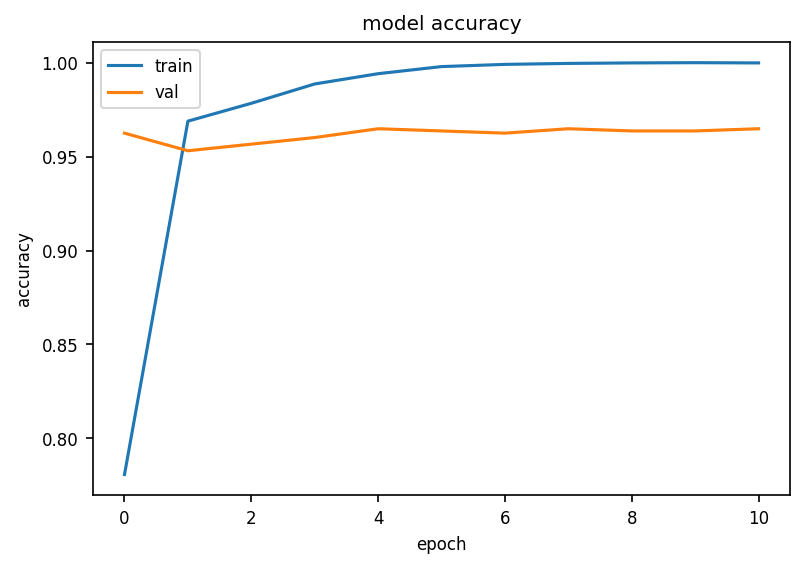

Validation accuracy:  0.9648300117233294
Test accuracy:  0.9700690713737529
CPU times: user 37.1 s, sys: 617 ms, total: 37.7 s
Wall time: 21.4 s


In [49]:
classifier = create_dnn_model()
%time train_model(classifier=classifier, X_data=X_data_tfidf_ngram_svd, y_data=y_data_n, X_test=X_test_tfidf_ngram_svd, y_test=y_test_n, is_neuralnet=True)

In [50]:
score = classifier.evaluate(X_test_tfidf_ngram_svd, y_test_n, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.12652939558029175
Test accuracy:  0.9700690507888794


In [51]:
y_pred = classifier.predict(X_test_tfidf_ngram_svd)
print(y_pred)

[[9.9976915e-01 2.2919624e-04 1.6496033e-06]
 [6.5001757e-07 9.9999893e-01 4.9232955e-07]
 [9.9998593e-01 1.3995060e-05 1.6724752e-07]
 ...
 [1.7760335e-08 3.8283055e-08 1.0000000e+00]
 [6.1629674e-10 3.0907326e-08 1.0000000e+00]
 [2.6908674e-07 8.5206727e-07 9.9999893e-01]]


# LSTM - Long-short term memory


In [52]:
from keras.layers import Dense, Input, Reshape, LSTM
from keras import models

def create_lstm_model():
    input_layer = Input(shape=(300,))
    
    layer = Reshape((10, 30))(input_layer)
    layer = LSTM(128, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    
    output_layer = Dense(3, activation='softmax')(layer)
    
    classifier = models.Model(input_layer, output_layer)
    
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

Epoch 1/100
15/15 [==============================] - 5s 119ms/step - loss: 1.0951 - accuracy: 0.3613 - val_loss: 1.0937 - val_accuracy: 0.3587
Epoch 2/100
15/15 [==============================] - 1s 100ms/step - loss: 1.0473 - accuracy: 0.4736 - val_loss: 0.9208 - val_accuracy: 0.5545
Epoch 3/100
15/15 [==============================] - 1s 99ms/step - loss: 0.7201 - accuracy: 0.6366 - val_loss: 0.7448 - val_accuracy: 0.6413
Epoch 4/100
15/15 [==============================] - 1s 99ms/step - loss: 0.5878 - accuracy: 0.6915 - val_loss: 0.5696 - val_accuracy: 0.6905
Epoch 5/100
15/15 [==============================] - 1s 99ms/step - loss: 0.4773 - accuracy: 0.7723 - val_loss: 0.4847 - val_accuracy: 0.7925
Epoch 6/100
15/15 [==============================] - 1s 99ms/step - loss: 0.3887 - accuracy: 0.8460 - val_loss: 0.4231 - val_accuracy: 0.8382
Epoch 7/100
15/15 [==============================] - 1s 99ms/step - loss: 0.3241 - accuracy: 0.8834 - val_loss: 0.3780 - val_accuracy: 0.8640
Epoc

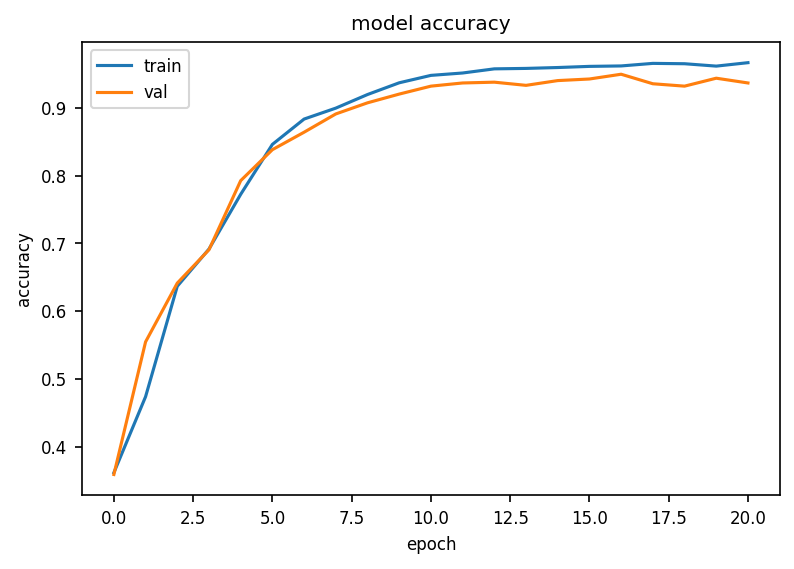

Validation accuracy:  0.936694021101993
Test accuracy:  0.9569126192303475
CPU times: user 59.9 s, sys: 2.59 s, total: 1min 2s
Wall time: 38.1 s


In [53]:
classifier = create_lstm_model()
%time train_model(classifier=classifier, X_data=X_data_tfidf_ngram_svd, y_data=y_data_n, X_test=X_test_tfidf_ngram_svd, y_test=y_test_n, is_neuralnet=True, n_epochs=100)

In [54]:
score = classifier.evaluate(X_test_tfidf_ngram_svd, y_test_n, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.1289660483598709
Test accuracy:  0.956912636756897


In [55]:
y_pred = classifier.predict(X_test_tfidf_ngram_svd)
print(y_pred)

[[9.8975742e-01 7.9560867e-03 2.2864393e-03]
 [1.6924874e-01 8.1721461e-01 1.3536610e-02]
 [9.9431372e-01 3.1229919e-03 2.5633490e-03]
 ...
 [7.9087353e-05 1.0245391e-03 9.9889636e-01]
 [3.3005246e-05 8.8129484e-04 9.9908566e-01]
 [9.3554510e-05 2.6970448e-03 9.9720937e-01]]


# Doc2Vec


In [57]:
train_corpus = get_corpus(X_data_3topic)
test_corpus = get_corpus(X_test_3topic)

100%|██████████| 18242/18242 [00:02<00:00, 6338.68it/s]


In [58]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=40)
model.build_vocab(train_corpus)

%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 8min 56s, sys: 6.12 s, total: 9min 2s
Wall time: 5min 6s


In [59]:
model.save('/content/drive/MyDrive/XLNNTN/doc2vec_3topic')

In [ ]:
model = gensim.models.doc2vec.Doc2Vec.load('/content/drive/MyDrive/XLNNTN/doc2vec_3topic')

In [60]:
X_data_vectors = []
for x in train_corpus:
    vector = model.infer_vector(x.words)
    X_data_vectors.append(vector)
    
X_test_vectors = []
for x in test_corpus:
    vector = model.infer_vector(x.words)
    X_test_vectors.append(vector)

In [61]:
pickle.dump(X_data_vectors, open('/content/drive/MyDrive/XLNNTN/X_data_vectors_3topic.pkl', 'wb'))
pickle.dump(X_test_vectors, open('/content/drive/MyDrive/XLNNTN/X_test_vectors_3topic.pkl', 'wb'))

In [ ]:
X_data_vector = pickle.load(open('/content/drive/MyDrive/XLNNTN/X_data_vectors_3topic.pkl', 'rb'))
X_test_vector = pickle.load(open('/content/drive/MyDrive/XLNNTN/X_test_vectors_3topic.pkl', 'rb'))

# Linear Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CPU times: user 2.11 s, sys: 478 ms, total: 2.58 s
Wall time: 1.37 s


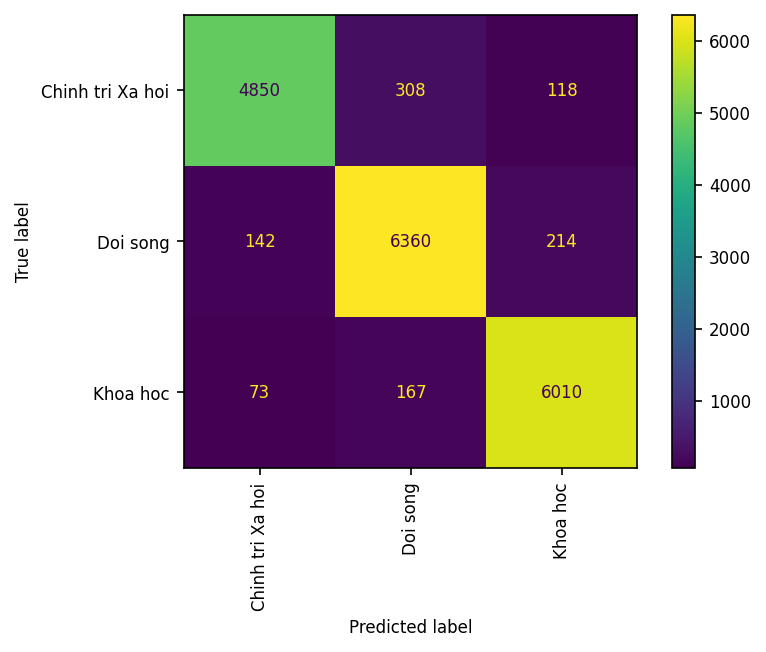

              precision    recall  f1-score   support

  Kinh doanh       0.96      0.92      0.94      5276
    The gioi       0.93      0.95      0.94      6716
     Van hoa       0.95      0.96      0.95      6250

    accuracy                           0.94     18242
   macro avg       0.95      0.94      0.94     18242
weighted avg       0.94      0.94      0.94     18242

Validation accuracy:  0.9460726846424384
Test accuracy:  0.9439754412893323


In [62]:
from sklearn import linear_model
train_model(linear_model.LogisticRegression(), X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=False)

# Naive Bayes

CPU times: user 72.6 ms, sys: 7.99 ms, total: 80.6 ms
Wall time: 82.1 ms


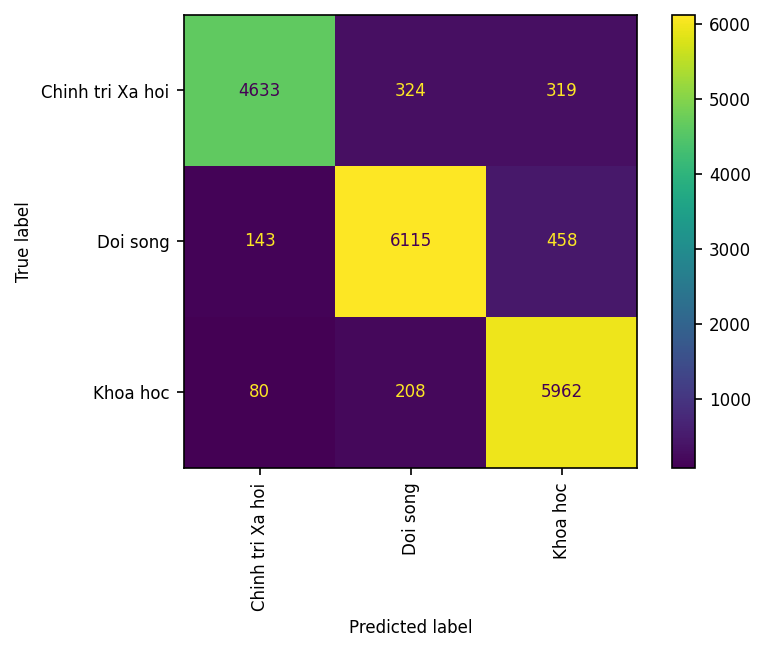

              precision    recall  f1-score   support

  Kinh doanh       0.95      0.88      0.91      5276
    The gioi       0.92      0.91      0.92      6716
     Van hoa       0.88      0.95      0.92      6250

    accuracy                           0.92     18242
   macro avg       0.92      0.91      0.92     18242
weighted avg       0.92      0.92      0.92     18242

Validation accuracy:  0.9003516998827668
Test accuracy:  0.916017980484596


In [67]:
from sklearn import naive_bayes
train_model(naive_bayes.BernoulliNB(), X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=False)

# Support Vector Machine (SVM)

CPU times: user 5.64 s, sys: 23 ms, total: 5.67 s
Wall time: 8.42 s


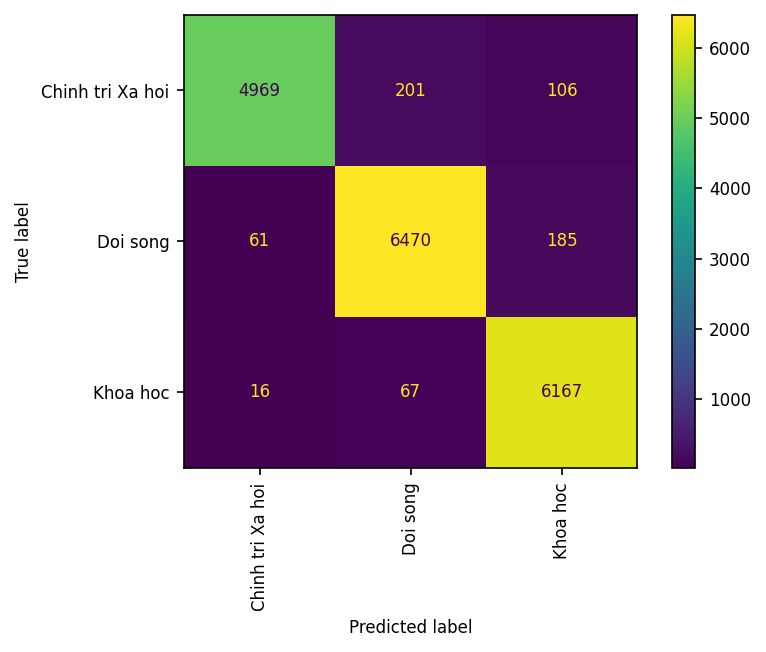

              precision    recall  f1-score   support

  Kinh doanh       0.98      0.94      0.96      5276
    The gioi       0.96      0.96      0.96      6716
     Van hoa       0.95      0.99      0.97      6250

    accuracy                           0.97     18242
   macro avg       0.97      0.96      0.97     18242
weighted avg       0.97      0.97      0.97     18242

Validation accuracy:  0.9683470105509965
Test accuracy:  0.9651354018199759


In [64]:
from sklearn import svm
train_model(svm.SVC(), X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=False)

# KNN

k = 3

CPU times: user 3.72 ms, sys: 0 ns, total: 3.72 ms
Wall time: 3.75 ms


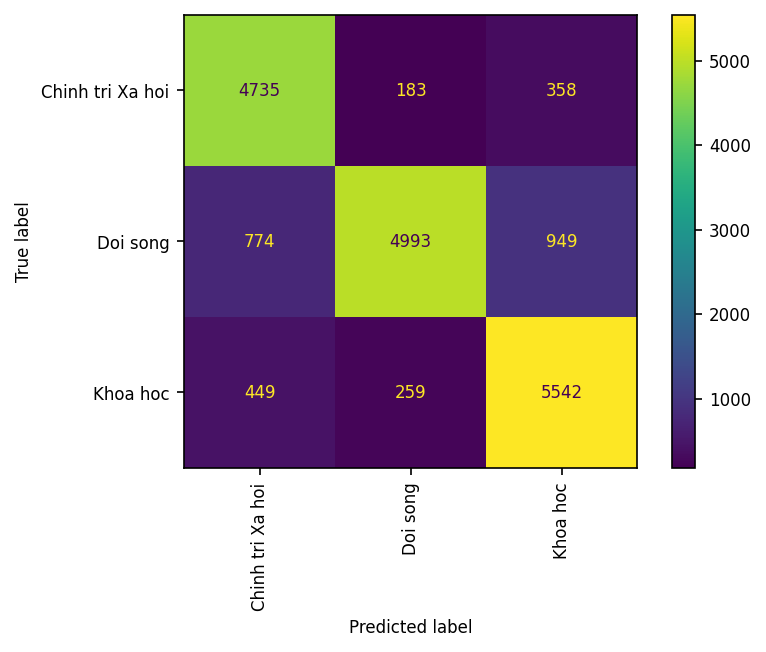

              precision    recall  f1-score   support

  Kinh doanh       0.79      0.90      0.84      5276
    The gioi       0.92      0.74      0.82      6716
     Van hoa       0.81      0.89      0.85      6250

    accuracy                           0.84     18242
   macro avg       0.84      0.84      0.84     18242
weighted avg       0.85      0.84      0.84     18242

Validation accuracy:  0.8030480656506448
Test accuracy:  0.8370792676241641


In [68]:
from sklearn import neighbors

train_model(neighbors.KNeighborsClassifier(n_neighbors=3, p=2), X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=False)

# Deep Neural Network (DNN)

In [69]:
from keras.layers import Dense, Input
from keras import models

def create_dnn_model():
    input_layer = Input(shape=(300,))
    layer = Dense(1024, activation='relu')(input_layer)
    layer = Dense(1024, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    output_layer = Dense(3, activation='softmax')(layer)
    
    classifier = models.Model(input_layer, output_layer)
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

Epoch 1/50
15/15 [==============================] - 2s 124ms/step - loss: 0.6577 - accuracy: 0.7522 - val_loss: 0.1684 - val_accuracy: 0.9461
Epoch 2/50
15/15 [==============================] - 2s 111ms/step - loss: 0.1223 - accuracy: 0.9614 - val_loss: 0.1563 - val_accuracy: 0.9531
Epoch 3/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0653 - accuracy: 0.9763 - val_loss: 0.1455 - val_accuracy: 0.9601
Epoch 4/50
15/15 [==============================] - 2s 116ms/step - loss: 0.0286 - accuracy: 0.9918 - val_loss: 0.1341 - val_accuracy: 0.9601
Epoch 5/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0154 - accuracy: 0.9965 - val_loss: 0.1344 - val_accuracy: 0.9613
Epoch 6/50
15/15 [==============================] - 2s 111ms/step - loss: 0.0069 - accuracy: 0.9990 - val_loss: 0.1478 - val_accuracy: 0.9625
Epoch 7/50
15/15 [==============================] - 2s 109ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.1635 - val_accuracy: 0.9613
Epoch 

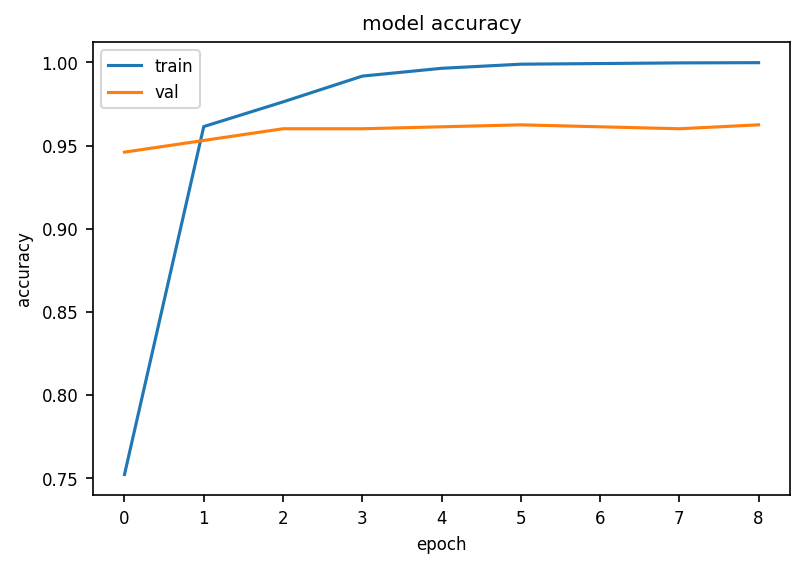

Validation accuracy:  0.9624853458382181
Test accuracy:  0.9613529218287469
CPU times: user 31.8 s, sys: 628 ms, total: 32.5 s
Wall time: 18.7 s


In [70]:
import numpy as np

classifier = create_dnn_model()
%time train_model(classifier=classifier, X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=True)

In [71]:
score = classifier.evaluate(np.array(X_test_vectors), y_test_n, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.23875783383846283
Test accuracy:  0.9613529443740845


In [72]:
y_pred = classifier.predict(np.array(X_test_vectors))
print(y_pred)

[[9.9996614e-01 3.3897282e-05 2.1118019e-08]
 [1.7771751e-04 9.9982220e-01 1.1991737e-07]
 [1.0000000e+00 2.0592529e-08 6.7418054e-10]
 ...
 [1.3291016e-07 1.4981078e-12 9.9999988e-01]
 [4.3611657e-09 6.7166011e-09 1.0000000e+00]
 [2.1595832e-10 6.9145654e-11 1.0000000e+00]]


# Long-short Term Memory (LSTM)

In [73]:
from keras.layers import Dense, Input, Reshape, LSTM
from keras import models

def create_lstm_model():
    input_layer = Input(shape=(300,))
    
    layer = Reshape((10, 30))(input_layer)
    layer = LSTM(128, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    
    output_layer = Dense(3, activation='softmax')(layer)
    
    classifier = models.Model(input_layer, output_layer)
    
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

Epoch 1/50
15/15 [==============================] - 3s 126ms/step - loss: 0.8797 - accuracy: 0.5961 - val_loss: 0.6028 - val_accuracy: 0.7479
Epoch 2/50
15/15 [==============================] - 1s 100ms/step - loss: 0.5410 - accuracy: 0.7895 - val_loss: 0.4447 - val_accuracy: 0.8300
Epoch 3/50
15/15 [==============================] - 2s 101ms/step - loss: 0.3997 - accuracy: 0.8477 - val_loss: 0.3588 - val_accuracy: 0.8675
Epoch 4/50
15/15 [==============================] - 2s 100ms/step - loss: 0.3253 - accuracy: 0.8781 - val_loss: 0.2849 - val_accuracy: 0.9004
Epoch 5/50
15/15 [==============================] - 2s 101ms/step - loss: 0.2508 - accuracy: 0.9083 - val_loss: 0.2479 - val_accuracy: 0.9074
Epoch 6/50
15/15 [==============================] - 1s 100ms/step - loss: 0.2160 - accuracy: 0.9234 - val_loss: 0.2386 - val_accuracy: 0.9144
Epoch 7/50
15/15 [==============================] - 2s 101ms/step - loss: 0.1920 - accuracy: 0.9306 - val_loss: 0.2289 - val_accuracy: 0.9215
Epoch 

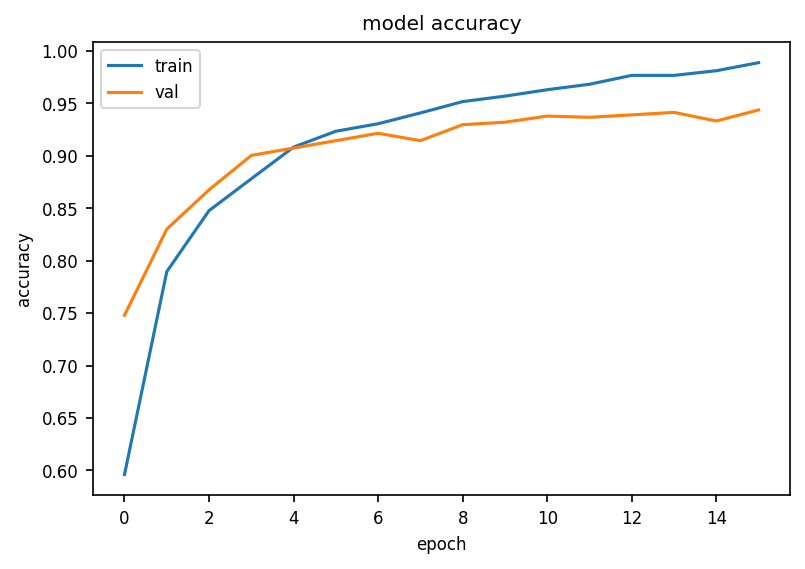

Validation accuracy:  0.943728018757327
Test accuracy:  0.9188137265650697
CPU times: user 47.7 s, sys: 2.08 s, total: 49.7 s
Wall time: 45.6 s


In [74]:
classifier = create_lstm_model()
%time train_model(classifier=classifier, X_data=np.array(X_data_vectors), y_data=y_data_n, X_test=np.array(X_test_vectors), y_test=y_test_n, is_neuralnet=True)

In [75]:
score = classifier.evaluate(np.array(X_test_vectors), y_test_n, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.3905942142009735
Test accuracy:  0.9188137054443359


In [76]:
y_pred = classifier.predict(np.array(X_test_vectors))
print(y_pred)

[[1.4436045e-01 8.5552931e-01 1.1021226e-04]
 [7.5411312e-03 9.9245161e-01 7.2594930e-06]
 [9.9751854e-01 2.3273495e-03 1.5408608e-04]
 ...
 [8.3459932e-09 4.4299511e-14 1.0000000e+00]
 [3.0825026e-07 7.3543220e-08 9.9999964e-01]
 [5.0702949e-09 4.7330051e-10 1.0000000e+00]]
